# Income Classification

The below model uses census income data to predict whether an individual's income is above or below $50,000/year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# Define Functions

In [57]:
def plot_stacked_hist(df, col, range=None, figsize=(6,4)):
    # stacked histogram - the top color (should be green) indicates income above $50k/year

    df_low_inc = df[df['income']=='- 50000.'][col]
    df_high_inc = df[df['income']=='50000+.'][col]

    plt.figure(figsize=figsize)
    
    if range:
        plt.hist([df_low_inc,df_high_inc], stacked=True, alpha=0.8, range=range)
    else:
        plt.hist([df_low_inc,df_high_inc], stacked=True, alpha=0.8)
    plt.show()

In [115]:
def barplot_categorical(df, x, figsize=(6,4)):
    # bar plot for categorical data

    # order columns by value count
    df_grouped = df.groupby(x)['income_binary'].mean().reset_index()
    val_cnt_sort = df[x].value_counts().index
    mapping = {val:i for i,val in enumerate(val_cnt_sort)}
    key = df_grouped[x].map(mapping)
    df_grouped = df_grouped.iloc[key.argsort()]
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y='income_binary',data=df_grouped, ax=ax, alpha=0.8, ci="sd")

    # include mean line
    mean_income = df['income_binary'].mean()
    plt.axhline(mean_income, 0, 1, color='black')

    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel('mean binary income')
    plt.show()

In [114]:
def barplot_numeric(df, x, figsize=(6,4)):
    # bar plot for numeric data - better than boxplot here due to high number of outliers
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y='income', data=df, ax=ax,alpha=0.8, ci="sd")
    plt.xlabel(x)
    plt.ylabel('income')
    
    plt.show()

In [5]:
def plot_value_counts(df, x, figsize=(6,4)):
    # bar plot of value counts used to provide additional color around categorical data
    
    value_cnts = df[x].value_counts()
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(value_cnts.index, value_cnts.values, ax=ax, alpha=0.8)
    
    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel('value_counts')
    plt.show()

In [6]:
def create_dummies(df, col, drop_val=None):
    # create dummy variables
    
    df[col] = df[col].astype('category')
    df = pd.get_dummies(df, columns=[col])
    
    if drop_val:
        new_drop_col = col + '_' + drop_val
        df = df.drop(new_drop_col, axis=1)
    return df

In [8]:
def create_col_bins(df, col, quantiles):
    # create bins for columns where distribution is uneven or we want to reduce the complexity
    # create bins and then replace bin range with average value
    
    col_bins = col + '_bins'
    col_min = col + '_min'
    col_max = col + '_max'
    col_final = col + '_binned'
    
    df[col_bins] = pd.cut(df[col], quantiles, include_lowest=True) 
    # get min value
    df[col_min] = df[col_bins].apply(lambda x: x.left)
    # get max value
    df[col_max] = df[col_bins].apply(lambda x: x.right)
    # get avg value
    df[col_final] = ((df[col_min]+df[col_max])/2).round(1)

    # drop columns that we no longer need
    df = df.drop([col, col_bins, col_min, col_max], axis=1)
    return df

In [7]:
def get_mean_binary_income(df):
    # get mean value of df - useful for comparing subsets of category to see if there might be signal
    
    mean_inc = round(df['income_binary'].mean(),3)
    return mean_inc

In [249]:
def calculate_pct_val(df, col, val):
    # calculate %of column that belongs to a given value
    
    pct_val = round(1.0*len(df[df[col]==val])/len(df),3)
    return pct_val

_____

# Initial Data Cleanup

I've excluded certain features, which were either highly correlated with or explained by other features already included in the model (for example, enrollin_edu was highly correlated with age), or just did not provide signal.

In [174]:
col_dict = {0:'age',
            1: 'class_of_worker',
            4: 'education',
            5: 'wage_per_hour',
            7: 'marital_stat',
            8: 'maj_industry_code',
            9: 'maj_occupation_code',
            10: 'race',
            11: 'hispanic',
            12: 'sex',
            13: 'labor_union',
            15: 'full_part_time',
            16: 'capital_gains',
            17: 'capital_losses',
            18: 'stock_dividends',
            34: 'country_of_birth_self',
            35: 'citizenship',
            39: 'wks_worked_in_yr',
            40: 'year',
            41: 'income'}

In [158]:
def remove_whitespace(df):
    # Remove whitespace from string values
    
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].str.strip()
    return df

def initial_data_processing(filename, col_dict):
    # Prepreocess data for feature audit
    
    col_nums = col_dict.keys()
    df = pd.read_csv(filename, header=None, usecols=col_nums)
    df = df.rename(columns=col_dict)
    df = remove_whitespace(df)
    
    # convert outcome variable to a binary column
    df['income_binary'] = np.where(df['income']=='- 50000.', 0, 1)
    
    return df

df = initial_data_processing('data/census_income_learn.csv', col_dict)

Analyze null values...

In [159]:
def create_nulls(df):
    # We should treat these rows as null, since they don't really contain any information
    
    df = df.replace('Not in universe', np.NaN)
    df = df.replace('Not in universe or children', np.NaN)
    df = df.replace('?', np.NaN)
    return df

df_with_nulls = create_nulls(df)

In [160]:
null_vals_df = df_with_nulls.isnull().sum().to_frame().rename(columns={0:'null_values'})
null_vals_df = null_vals_df[null_vals_df['null_values']>0]
null_vals_df['% null'] = (null_vals_df['null_values']/len(df)).round(3)
null_vals_df

,null_values,% null
class_of_worker,100245,0.502
maj_industry_code,100684,0.505
maj_occupation_code,100684,0.505
labor_union,180459,0.904
unemployment_reason,193453,0.970
country_of_birth_self,3393,0.017


* About half of the values in Class of Worker, Major Industry Code, and Major Occupation Code are null
* 1.7% of the values in Country of Birth (Self) are null
* We will investigate further, but since these features are categorical, we may be able to just include the nulls in with a baseline group when we create dummy variables

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 22 columns):
age                      199523 non-null int64
class_of_worker          199523 non-null object
education                199523 non-null object
wage_per_hour            199523 non-null int64
marital_stat             199523 non-null object
maj_industry_code        199523 non-null object
maj_occupation_code      199523 non-null object
race                     199523 non-null object
hispanic                 199523 non-null object
sex                      199523 non-null object
labor_union              199523 non-null object
unemployment_reason      199523 non-null object
full_part_time           199523 non-null object
capital_gains            199523 non-null int64
capital_losses           199523 non-null int64
stock_dividends          199523 non-null int64
country_of_birth_self    199523 non-null object
citizenship              199523 non-null object
wks_worked_in_yr         19952

# Feature Audit - Age

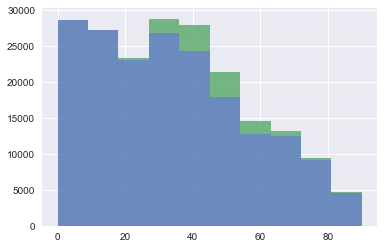

In [79]:
plot_stacked_hist(df, 'age')

* Age appears to be nonlinear - the middle ages are associated with higher income while the younger and older ages are associated with lower

In [42]:
def preprocess_age(df):
    # Bin ages
    
    quantiles = [0,18,25,30,35,40,45,50,55,60,65,70,80,90]
    df = create_col_bins(df, 'age', quantiles)
    return df

# Feature Audit - Class of Worker

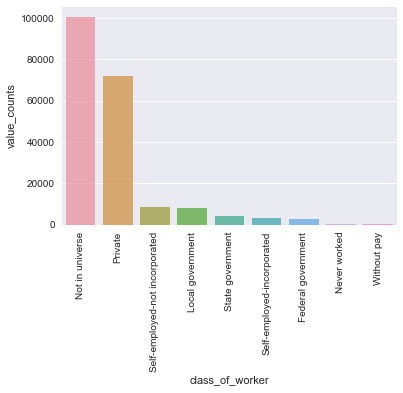

In [44]:
plot_value_counts(df, 'class_of_worker')

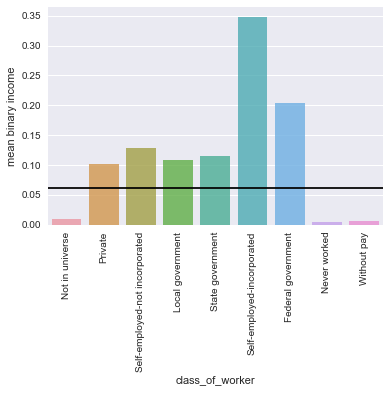

In [127]:
barplot_categorical(df, 'class_of_worker')

* Not in Universe and Private classes have by far the highest count
* Private, self-employed, and government classes all seem to be associated w/ higher income

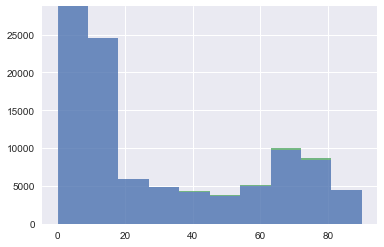

In [60]:
#explore nulls - see if they are correlated w/ age

df_cow_null = df[df['class_of_worker']=='Not in universe']
plot_stacked_hist(df_cow_null,'age')

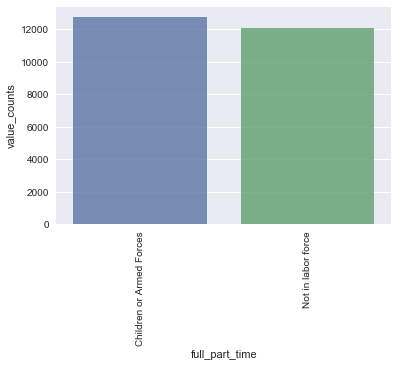

In [176]:
df_cow_null_mid_age = df_cow_null[(df_cow_null['age']>18) &(df_cow_null['age']<65)]

plot_value_counts(df_cow_null_mid_age, 'full_part_time')

* Looks like these null values are fairly correlated with age
* The middle aged employees with no COW are either in the Armed Forces or not in the labor force

In [80]:
def preprocess_class_of_worker(df):
    # Group government and self-employed categories and create dummy variables
    
    gov = ['Local government','State government', 'Federal government']
    self_employed = ['Self-employed-not incorporated', 'Self-employed-incorporated']
    
    df['COW_government'] = np.where(df['class_of_worker'].isin(gov),1,0)
    df['COW_self_employed'] = np.where(df['class_of_worker'].isin(self_employed),1,0)
    df['COW_private'] = np.where(df['class_of_worker']=='Private',1,0)
    
    df = df.drop('class_of_worker',axis=1)
    
    return df

# Feature Audit - Education

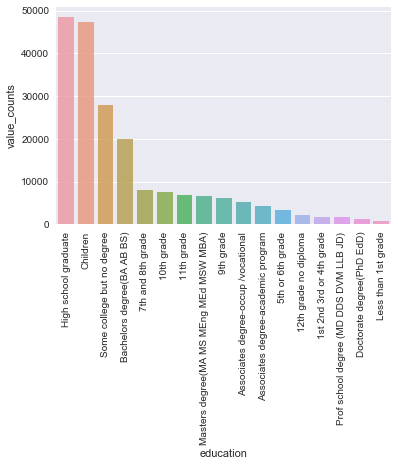

In [81]:
plot_value_counts(df, 'education')

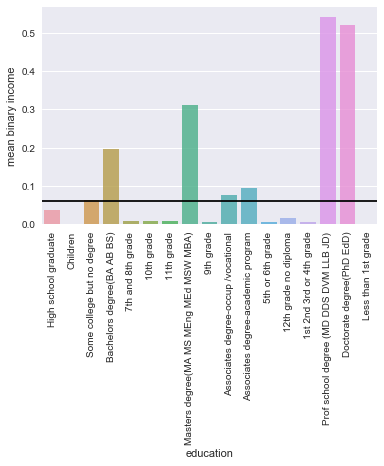

In [82]:
barplot_categorical(df, 'education')

* We can definitely bucket these together, as we don't need to look at all of the individual categories beneath high school, for example
* It looks like having a bachelors degree, a masters degree, or a professional school/doctorate degree is associated w/ higher income

In [83]:
def preprocess_education(df):
    # Group education classes and create dummy variables
    
    no_high_school_degree = ['Less than 1st grade','1st 2nd 3rd or 4th grade','5th or 6th grade','7th and 8th grade','9th grade','10th grade','11th grade','12th grade no diploma']
    high_school = ['High school graduate', 'Some college but no degree']
    associates_degree = ['Associates degree-occup /vocational','Associates degree-academic program']
    prof_doctorate_degrees = ['Prof school degree (MD DDS DVM LLB JD)','Doctorate degree(PhD EdD)']

    df['educ_no_high_school_deg'] = np.where(df['education'].isin(no_high_school_degree), 1, 0)
    df['educ_high_school_deg'] = np.where(df['education'].isin(high_school), 1, 0)
    df['educ_assoc_deg'] = np.where(df['education'].isin(associates_degree), 1, 0)
    df['educ_bachelors_deg'] = np.where(df['education']=='Bachelors degree(BA AB BS)', 1, 0)
    df['educ_masters_deg'] = np.where(df['education']=='Masters degree(MA MS MEng MEd MSW MBA)', 1, 0)
    df['educ_prof_doctorate_deg'] = np.where(df['education'].isin(prof_doctorate_degrees), 1, 0)
    
    df = df.drop(['education'], axis=1)
    return df

# Feature Audit - Wage Per Hour

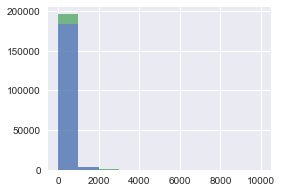

In [89]:
plot_stacked_hist(df, 'wage_per_hour', figsize=(4,3))

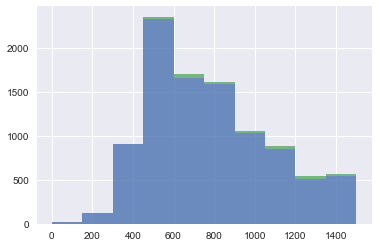

In [103]:
# let's zoom in here

plot_stacked_hist(df, 'wage_per_hour', range=(1,1500))

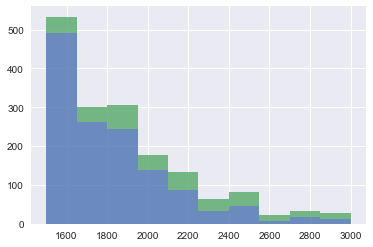

In [105]:
plot_stacked_hist(df, 'wage_per_hour', range=(1500,3000))

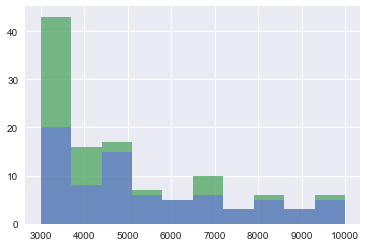

In [106]:
plot_stacked_hist(df, 'wage_per_hour', range=(3000,10000))

In [86]:
df['wage_per_hour'].describe()

count    199523.000000
mean         55.426908
std         274.896454
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9999.000000
Name: wage_per_hour, dtype: float64

In [287]:
calculate_pct_val(df, 'wage_per_hour', 0)

0.943

In [95]:
hourly_wage_zero = df[df['wage_per_hour']==0]
hourly_wage_pos = df[df['wage_per_hour']>0]

print get_mean_binary_income(hourly_wage_zero)
print get_mean_binary_income(hourly_wage_pos)
print round(df['income_binary'].mean(),3)

0.063
0.049
0.062


* 94% of the values are 0... Looks like a zero here indicates not getting paid hourly (or not getting paid at all), but overall this has a slightly positive associate association with income (mean for entire income column is 0.63 and when wage=0, it's 0.63)
* It also looks like some of the higher wage categories (namely, ~2000-4000/hr) are associated with much higher income
* We'll bin these ages to reduce the complexity and help somewhat with the skewed distribution

In [109]:
def preprocess_wage_per_hr(df):
    # Bin wage per hour
    
    quantiles = [0,.01,500,1000,1500,2000,3000,4000,7000,10000]
    df = create_col_bins(df, 'wage_per_hour', quantiles)
    return df

# Feature Audit - Industry Code

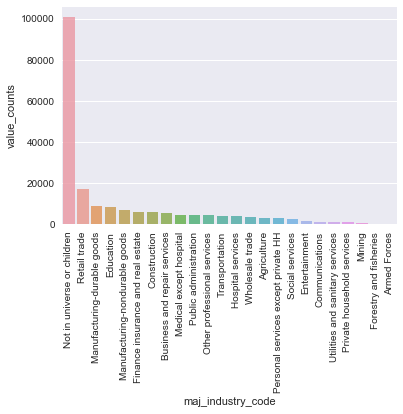

In [110]:
plot_value_counts(df, 'maj_industry_code')

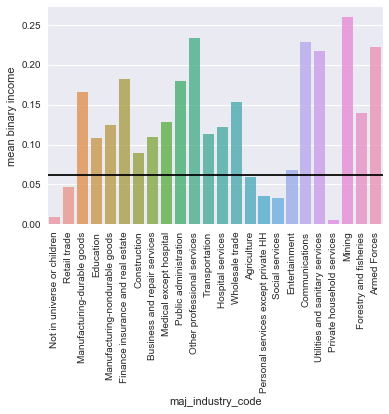

In [111]:
barplot_categorical(df, 'maj_industry_code')

* We can just loop these null values in with the 'Other' category which will be our dummy baseline
* Aside from retail trade, all of the top (by value counts) are associated w/ higher income
* I'll create dummy's just for everything up to Finance/Insurance/Real estate, because after that the signal appears less strong anyway

In [128]:
df['maj_industry_code'].value_counts()[1:6].index

Index([u'Retail trade', u'Manufacturing-durable goods', u'Education',
       u'Manufacturing-nondurable goods',
       u'Finance insurance and real estate'],
      dtype='object')

In [223]:
def preprocess_industry_code(df):
    keep_cols = df['maj_industry_code'].value_counts()[1:6].index
    df['maj_industry_code'] = np.where(df['maj_industry_code'].isin(keep_cols),df['maj_industry_code'],'Other')
    df = create_dummies(df, 'maj_industry_code', 'Other')
    
    return df

# Feature Audit - Occupation Code

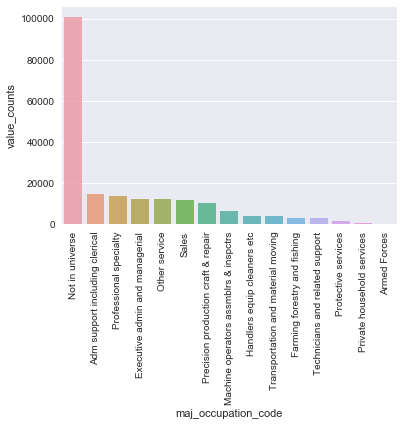

In [131]:
plot_value_counts(df, 'maj_occupation_code')

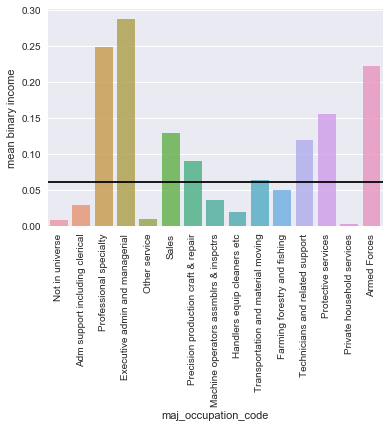

In [132]:
barplot_categorical(df, 'maj_occupation_code')

* Professional Specialty, Exec Admin, & Sales seem to be associated with higher income
* I'll group everything after Sales into an 'Other' category due to low value counts - we don't create a dummy variable for this category

In [134]:
list(df['maj_occupation_code'].value_counts()[1:6].index)

['Adm support including clerical',
 'Professional specialty',
 'Executive admin and managerial',
 'Other service',
 'Sales']

In [222]:
def preprocess_occupation_code(df):   
    # Create list of columns to include & create dummies for those features
    
    keep_cols = df['maj_occupation_code'].value_counts()[1:6].index
    df['maj_occupation_code'] = np.where(df['maj_occupation_code'].isin(keep_cols),df['maj_occupation_code'],'Other')
    df = create_dummies(df, 'maj_occupation_code', 'Other')
    
    return df

# Feature Audit - # Weeks Worked in Year

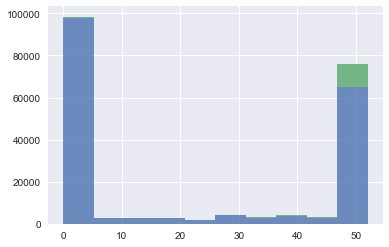

In [136]:
plot_stacked_hist(df, 'wks_worked_in_yr')

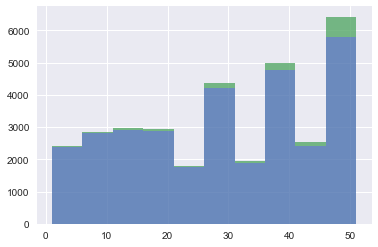

In [139]:
# zoom in

plot_stacked_hist(df, 'wks_worked_in_yr', range=(1,51))

* Working a full year seems to be associated with higher income
* Bin values to slightly offset skewed distribution

In [138]:
def preprocess_wks_worked(df):
    # Bin weeks worked in year
    
    quantiles = [0,.1,25,50,51.9,52]
    df = create_col_bins(df, 'wks_worked_in_yr', quantiles)
    return df

# Feature Audit - Race

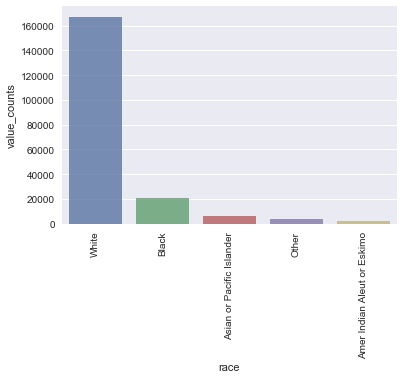

In [140]:
plot_value_counts(df, 'race')

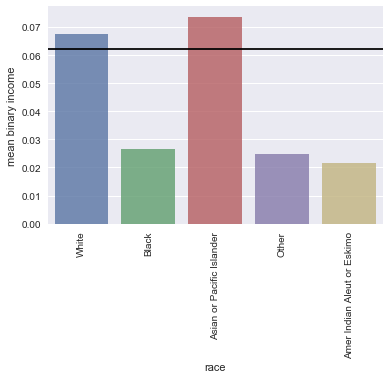

In [141]:
barplot_categorical(df, 'race')

* Being White or Asian/Pacific Islander seem to be associated w/ higher income

In [142]:
def preprocess_race(df):
    # group American Indian/Eskimo category in with 'Other' because it's fairly small and mean incomes are close
    df['race'] = df['race'].replace('Amer Indian Aleut or Eskimo','Other')
    
    df = create_dummies(df, 'race', 'Other')
    return df

# Feature Audit - Hispanic

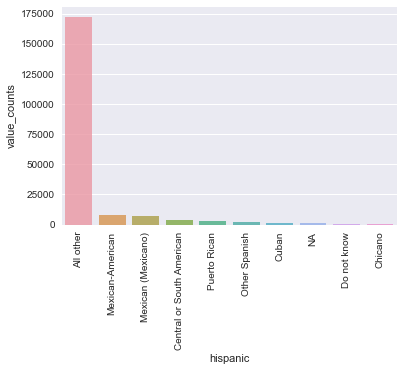

In [143]:
plot_value_counts(df, 'hispanic')

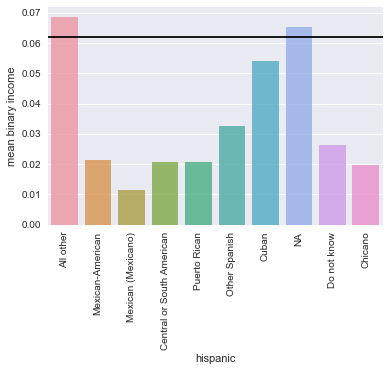

In [144]:
barplot_categorical(df, 'hispanic')

In [145]:
def preprocess_hispanic(df):
    df['hispanic'] = np.where(df['hispanic'].isin(['All Other','NA']),0,1)
    return df

# Feature Audit - Sex

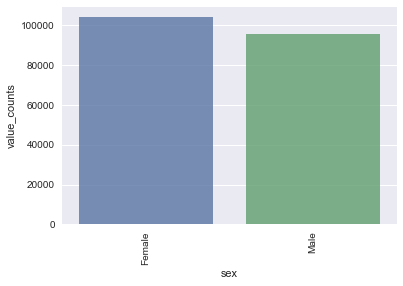

In [150]:
plot_value_counts(df, 'sex')

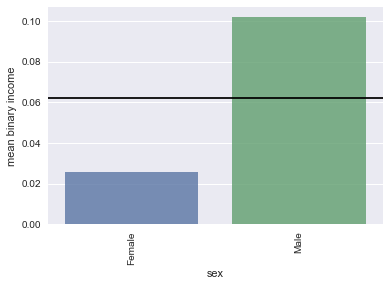

In [151]:
barplot_categorical(df, 'sex')

* Being male seems to be associated with higher income

In [152]:
def preprocess_sex(df):
    df['sex_male'] = df['sex'].replace({'Male':1, 'Female':0})
    df = df.drop('sex', axis=1)
    return df

# Feature Audit - Labor Union

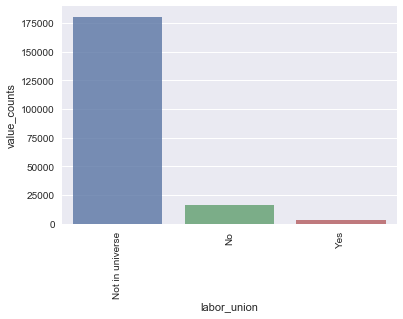

In [162]:
plot_value_counts(df, 'labor_union')

In [164]:
labor_union_df = df[df['labor_union']=='Yes']
1.0*len(labor_union_df)/len(df)

0.015186219132631325

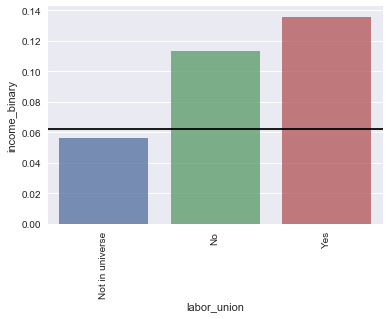

In [59]:
barplot_categorical(df, 'labor_union')

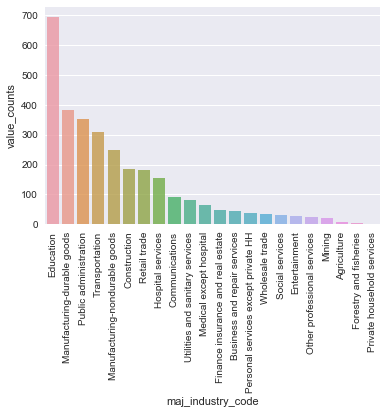

In [167]:
plot_value_counts(labor_union_df, 'maj_industry_code')

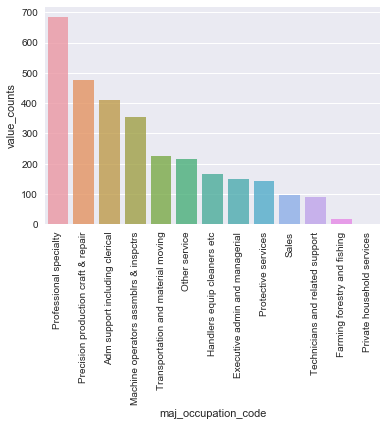

In [168]:
plot_value_counts(labor_union_df, 'maj_occupation_code')

* Labor union category is small and is correlated with other features such as industry and occupation code, but since we aren't including all industries/occupation codes, it may pick up on some additional signal

In [169]:
def preprocess_labor_union(df):
    df['labor_union'] = np.where(df['labor_union']=='Yes',1,0)
    return df

# Feature Audit - Full/Part Time

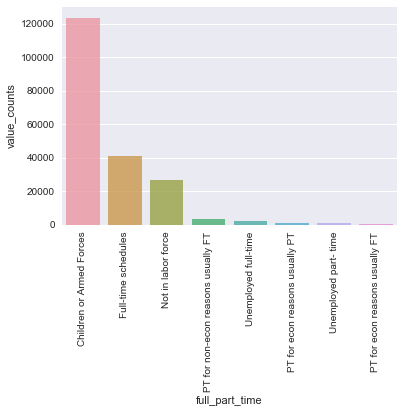

In [170]:
plot_value_counts(df, 'full_part_time')

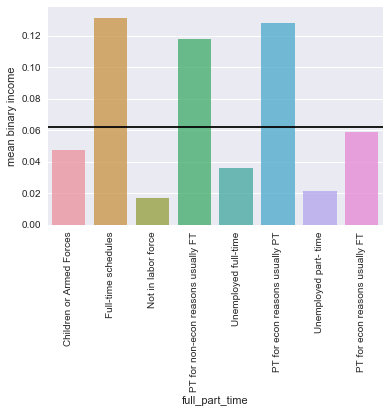

In [171]:
barplot_categorical(df, 'full_part_time')

* Working full time assoc/ with higher income
* Working part time assoc w/ higher income
* Unemployed assoc w/ lower income

In [173]:
df['full_part_time'].value_counts()

Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26808
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
PT for econ reasons usually PT          1209
Unemployed part- time                    843
PT for econ reasons usually FT           525
Name: full_part_time, dtype: int64

In [177]:
def preprocess_full_time(df):
    part_time = ['PT for non-econ reasons usually FT','PT for econ reasons usually PT','PT for econ reasons usually FT']
    unemployed = ['Unemployed full-time','Unemployed part-time']
    
    df['full_time'] = np.where(df['full_part_time']=='Full-time schedules',1,0)
    df['part_time'] = np.where(df['full_part_time'].isin(part_time),1,0)
    df['unemployed'] = np.where(df['full_part_time'].isin(unemployed),1,0)
    df = df.drop('full_part_time', axis=1)
    return df

# Feature Audit - Capital Gains

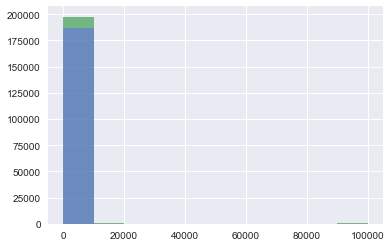

In [178]:
plot_stacked_hist(df, 'capital_gains')

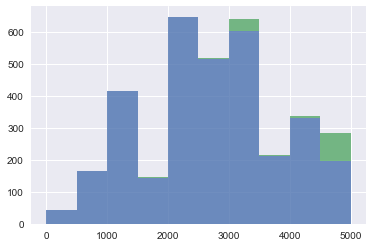

In [180]:
plot_stacked_hist(pos_cap_gains, 'capital_gains', range=(1,5000))

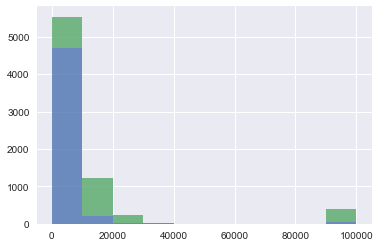

In [182]:
plot_stacked_hist(pos_cap_gains, 'capital_gains', range=(1,100000))

In [179]:
pos_cap_gains = df[df['capital_gains']>0]
zero_cap_gains = df[df['capital_gains']==0]

print get_mean_binary_income(zero_cap_gains)
print get_mean_binary_income(pos_cap_gains)

0.052
0.327


* Positive capital gains associated w/ higher income
* We can bin to slightly help w/ skewed dist

In [183]:
# bin capital gains

def preprocess_cap_gains(df):
    quantiles = [0, .001,150,1000,2500,3500,5000,7500,10000,15000,30000,100000]
    df = create_col_bins(df, 'capital_gains', quantiles)
    return df

# Feature Audit - Capital Losses

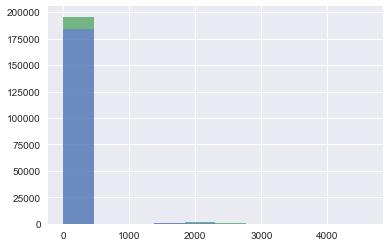

In [187]:
plot_stacked_hist(df, 'capital_losses')

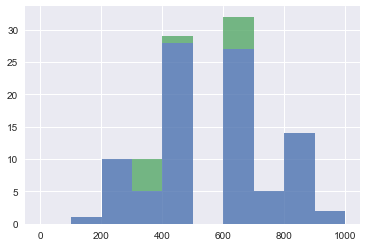

In [194]:
plot_stacked_hist(df, 'capital_losses', range=(1,1000))

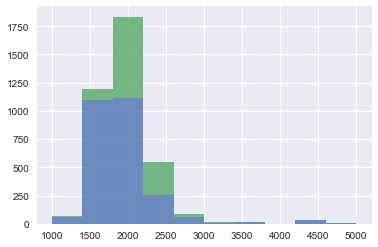

In [195]:
plot_stacked_hist(df, 'capital_losses', range=(1000,5000))

In [215]:
df['capital_losses'].describe()

count    199523.000000
mean         37.313788
std         271.896428
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4608.000000
Name: capital_losses, dtype: float64

In [196]:
# bin capital losses

def preprocess_cap_losses(df):
    quantiles = [0,.001,500,1500,2000,2500,5000]
    df = create_col_bins(df, 'capital_losses', quantiles)
    return df

# Feature Audit - Stock Dividends

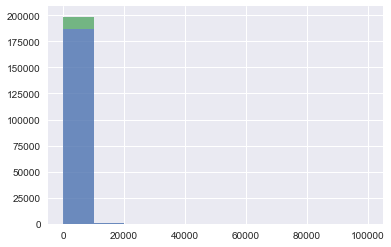

In [197]:
plot_stacked_hist(df, 'stock_dividends')

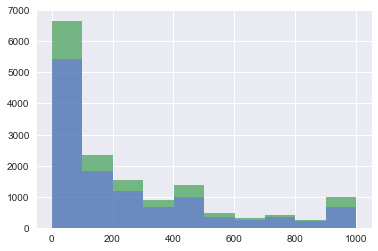

In [198]:
plot_stacked_hist(df, 'stock_dividends', range=(1,1000))

In [199]:
pos_dividends = df[df['stock_dividends']>0]
zero_dividends = df[df['stock_dividends']==0]

print get_mean_binary_income(pos_dividends)
print get_mean_binary_income(zero_dividends)

0.251
0.04


In [200]:
def preprocess_stock_dividends(df):
    
    pos_dividends_df = df[df['stock_dividends']>0.001]
    quantile_list = np.linspace(0.,1.,6)
    quantiles = pos_dividends_df['stock_dividends'].quantile(quantile_list)
    full_quantiles = [0,.001]
    full_quantiles.extend(quantiles)
    
    df = create_col_bins(df, 'stock_dividends', full_quantiles)
    return df

# Feature Audit - Country of Birth

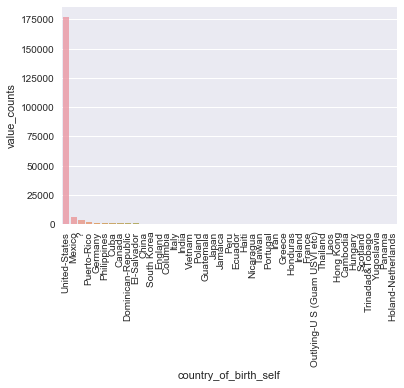

In [201]:
plot_value_counts(df, 'country_of_birth_self')

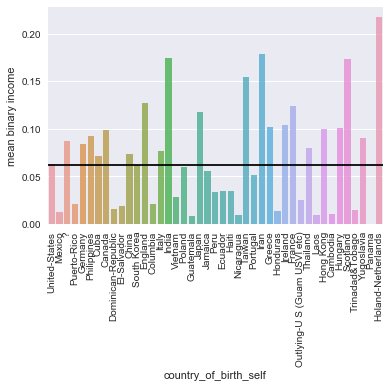

In [202]:
barplot_categorical(df, 'country_of_birth_self')

* Large majority of values are US
* Also included Mexico/Central/South/Amer ctg bc those countries are associated with much lower income and also have sufficient enough value counts
* The rest just didn't provide sufficient signal

In [204]:
# group countries

def preprocess_country_of_birth(df):
    mex_central_south_amer = ['El-Salvador','Guatemala','Honduras','Nicaragua','Panama','Columbia','Ecuador','Peru']
    df['Born_Mexico_Central_South_Amer'] = np.where(df['country_of_birth_self'].isin(mex_central_south_amer), 1, 0)
    df['Born_US'] = np.where(df['country_of_birth_self']=='United-States', 1, 0)
    
    df = df.drop(['country_of_birth_self'], axis=1)
    return df

# Feature Audit - Marital Status

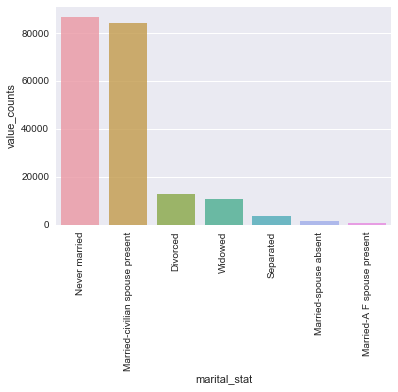

In [205]:
plot_value_counts(df, 'marital_stat')

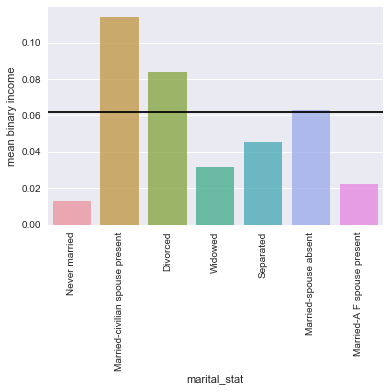

In [206]:
barplot_categorical(df, 'marital_stat')

In [207]:
def preprocess_marital_stat(df):
    # for the sake of simplicity, we can just group this into a binary 'married & civilian spouse present' column
    
    df['married_civilian_spouse_present'] = np.where(df['marital_stat']=='Married-civilian spouse present',1,0)
    df = df.drop('marital_stat', axis=1)
    return df

# Feature Audit - Citizenship

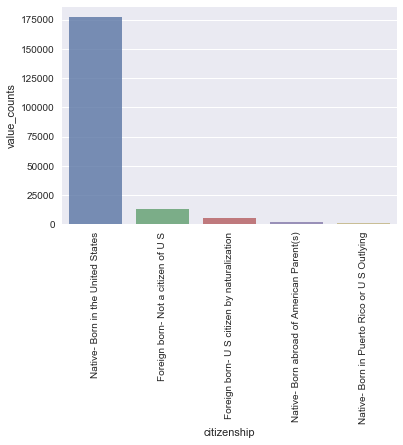

In [208]:
plot_value_counts(df, 'citizenship')

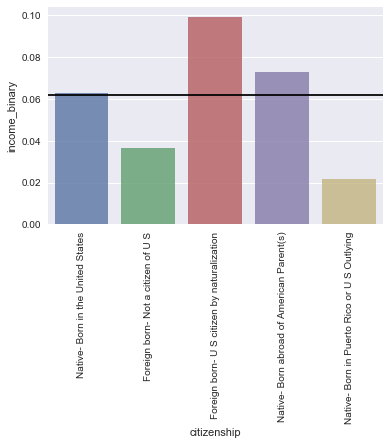

In [232]:
barplot_categorical(df, 'citizenship')

* Partially covered in the country of birth feature, but let's create a binary feature for foreign born but US citizen by naturalization since that is unique and seems to have a pretty strong relationship with income

In [209]:
def preprocess_citizenship(df):
    df['US_citizen_by_naturalization'] = np.where(df['citizenship']=='Foreign born- U S citizen by naturalization',1,0)
    df = df.drop('citizenship', axis=1)
    return df

# Feature Audit - Year

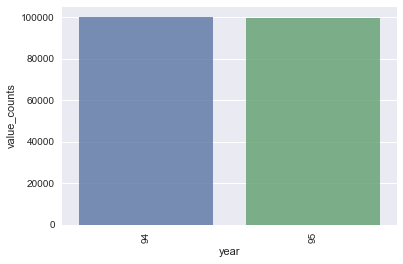

In [212]:
plot_value_counts(df, 'year')

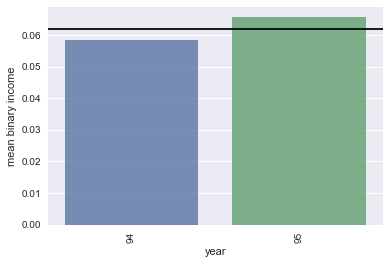

In [210]:
barplot_categorical(df, 'year')

* We can just leave these values as is

In [213]:
def preprocess_year(df):
    df['year_95'] = np.where(df['year']==95, 1, 0)
    df = df.drop('year', axis=1)
    return df

______________

# Modeling

In [214]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [215]:
# because the classes are imbalanced, we should look at the area under the ROC curve in addition to accuracy

pct_income_over_50k = round(1.*len(df[df['income_binary']==0])/len(df),3)
print "percent w/ income above 50k:", pct_income_over_50k

percent w/ income above 50k: 0.938


In [216]:
def score_model(clf, x_test, y_test):
    print "Accuracy: %.3f" %clf.score(x_test, y_test)
    print "AUC: %.3f" %roc_auc_score(y_test, clf.predict(x_test))
    return

In [217]:
def run_model(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    score_model(clf, x_test, y_test)
    return

In [218]:
def run_grid_search(clf, grid_params, x_train, y_train, score_type='roc_auc'):
    grid_cv = GridSearchCV(clf, grid_params, n_jobs=-1, scoring=score_type)
    grid_cv.fit(x_train, y_train)
    print "best parameters: ", grid_cv.best_params_
    
    best_model = grid_cv.best_estimator_
    return best_model

In [219]:
def plot_feature_importances(clf, x, num_feats=20):
    '''Plot feature importance'''
    feat_imp = clf.feature_importances_
    indices = np.argsort(feat_imp)[-num_feats:]
    sorted_features = x.columns[indices]
    
    plt.title("Feature importances")
    plt.barh(range(num_feats), feat_imp[indices], align="center")
    plt.yticks(range(num_feats), sorted_features)
    plt.show()

In [224]:
def preprocess_data(df):

    df = preprocess_age(df)
    df = preprocess_education(df)
    df = preprocess_full_time(df)
    df = preprocess_sex(df)
    df = preprocess_race(df)
    df = preprocess_marital_stat(df)
    df = preprocess_cap_gains(df)
    df = preprocess_hispanic(df)
    df = preprocess_cap_losses(df)
    df = preprocess_stock_dividends(df)
    df = preprocess_citizenship(df)
    df = preprocess_wage_per_hr(df)
    df = preprocess_country_of_birth(df)
    df = preprocess_class_of_worker(df)
    df = preprocess_wks_worked(df)
    df = preprocess_occupation_code(df)
    df = preprocess_industry_code(df)
    df = preprocess_year(df)
    df = preprocess_labor_union(df)
    df = df.drop(['income'], axis=1)
    
    return df

In [225]:
df = initial_data_processing('data/census_income_learn.csv', col_dict)
df_processed = preprocess_data(df)

In [227]:
x = df_processed.drop(['income_binary'], axis=1)
y = df['income_binary']

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values)

# Look at Data

In [228]:
# look at correlations

df_processed.corr().loc['income_binary'].sort_values(ascending=False)

income_binary                                          1.000000
capital_gains_binned                                   0.286457
wks_worked_in_yr_binned                                0.262452
educ_prof_doctorate_deg                                0.242970
maj_occupation_code_Executive admin and managerial     0.241584
maj_occupation_code_Professional specialty             0.212686
educ_masters_deg                                       0.190403
educ_bachelors_deg                                     0.186097
married_civilian_spouse_present                        0.183949
stock_dividends_binned                                 0.176232
sex_male                                               0.157610
full_time                                              0.146261
capital_losses_binned                                  0.142938
age_binned                                             0.135195
COW_self_employed                                      0.132337
COW_private                             

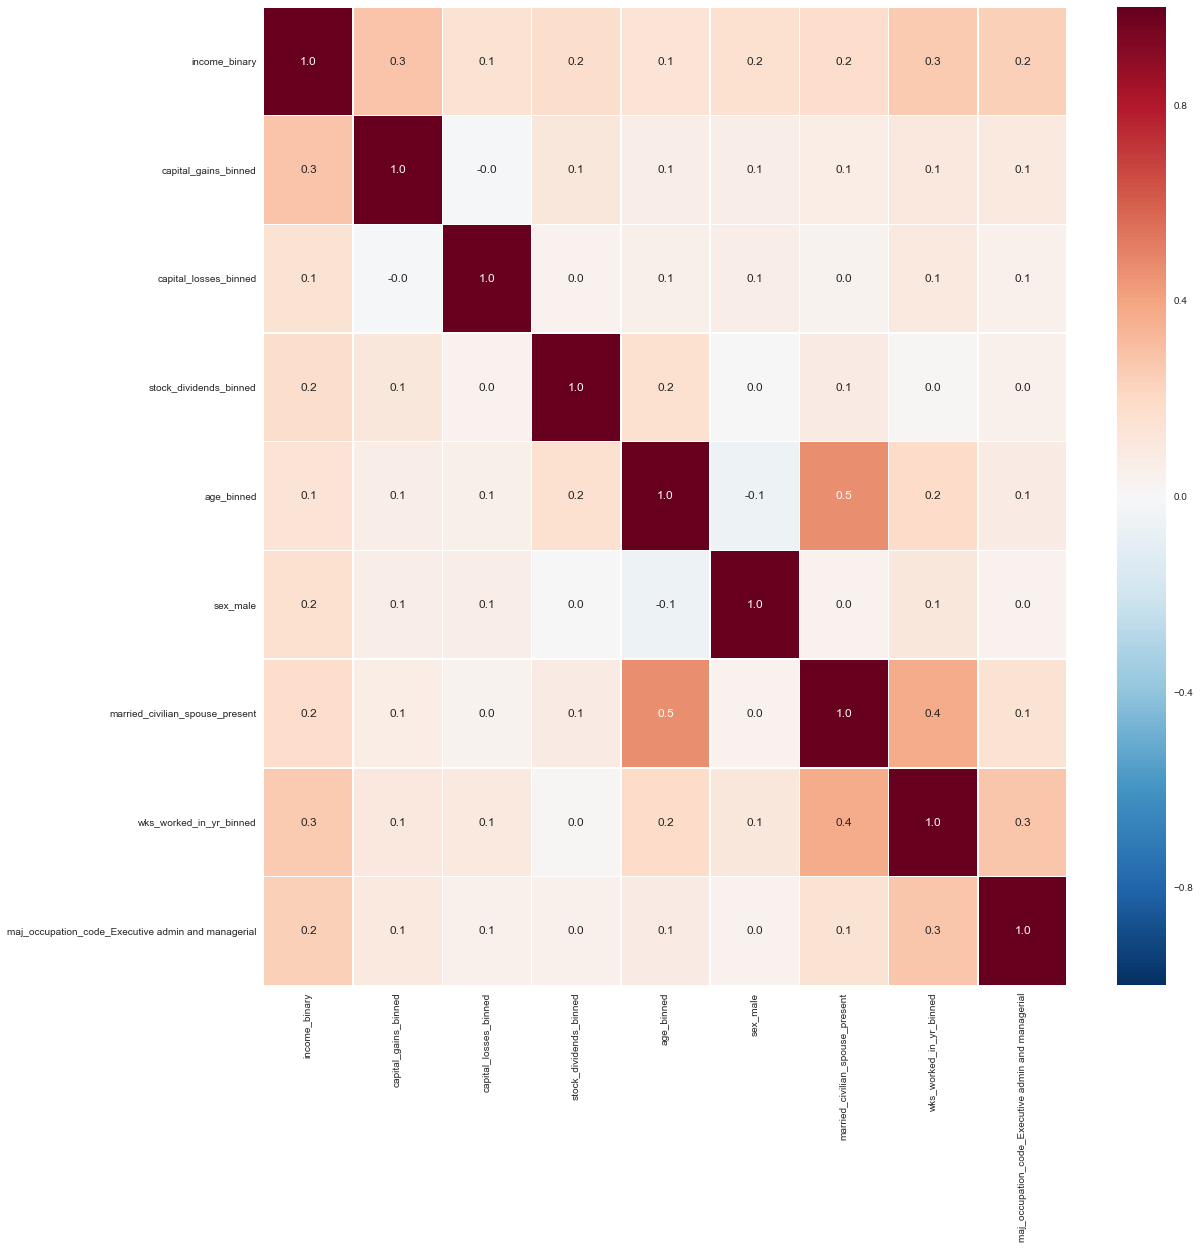

In [229]:
f,ax = plt.subplots(figsize = (18,18))
df_for_corr = df_processed[['income_binary','capital_gains_binned','capital_losses_binned',
                   'stock_dividends_binned','age_binned','sex_male','married_civilian_spouse_present',
                   'wks_worked_in_yr_binned','maj_occupation_code_Executive admin and managerial']]

sns.heatmap(df_for_corr.corr(),annot = True,linewidths = .5,fmt = '.1f',ax=ax,center = 0,vmin = -0.3,vmax = 1)
plt.show()

# Logistic Regression

Logistic regression is not going to be as accurate, since the model is non-linear

In [230]:
logistic = LogisticRegression()

In [231]:
run_model(logistic, x_train, y_train, x_test, y_test)

Accuracy: 0.947
AUC: 0.663


# Random Forest

In [238]:
rf = RandomForestClassifier()

run_model(rf, x_train, y_train, x_test, y_test)

Accuracy: 0.944
AUC: 0.692


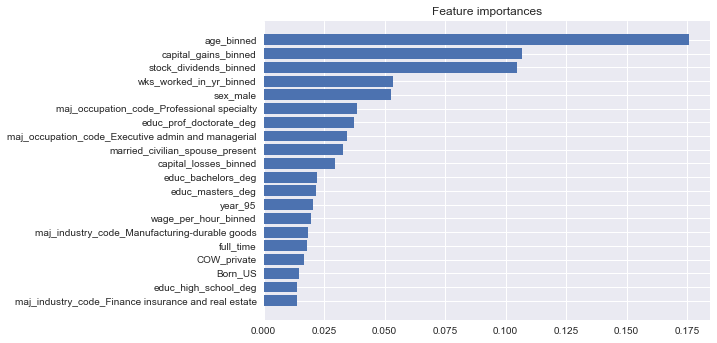

In [239]:
# plot_feature_importances(rf, x, higher_income_features)
plot_feature_importances(rf, x)

# Gradient Boosting

In [240]:
gbc = GradientBoostingClassifier()
run_model(gbc, x_train, y_train, x_test, y_test)

Accuracy: 0.952
AUC: 0.695


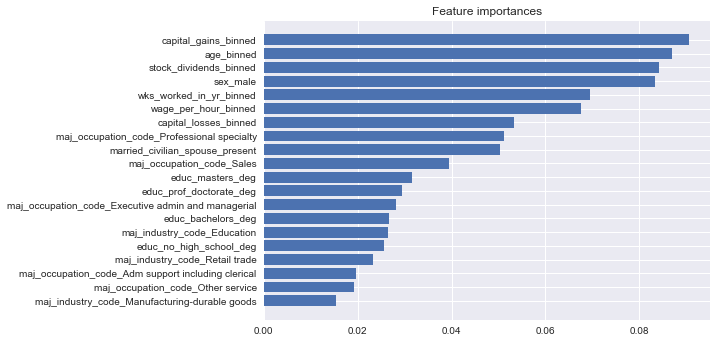

In [241]:
plot_feature_importances(gbc, x)

Gradient Boosting model looks best. Now grid search to tune parameters...

In [244]:
# first tune with high learning rate for speed purposes
grid_dict1 = {
    'learning_rate': [.2],
    'max_depth': [3, 5, 8],
    'min_samples_leaf': [1, 3, 5]}

In [245]:
gbc_grid1 = run_grid_search(gbc, grid_dict1, x_train, y_train)

best parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 3}


In [246]:
score_model(gbc_grid1, x_train, y_train)

Accuracy: 0.958
AUC: 0.724


In [247]:
grid_dict2 = {
    'learning_rate': [.1],
    'max_depth': [5],
    'min_samples_leaf': [3],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# gbc_grid2 = run_grid_search(gbc, grid_dict2, x_train, y_train)

best parameters:  {'learning_rate': 0.1, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 1.0, 'max_features': 'sqrt', 'max_depth': 5}


In [251]:
score_model(gbc_grid2, x_train, y_train)

Accuracy: 0.959
AUC: 0.726


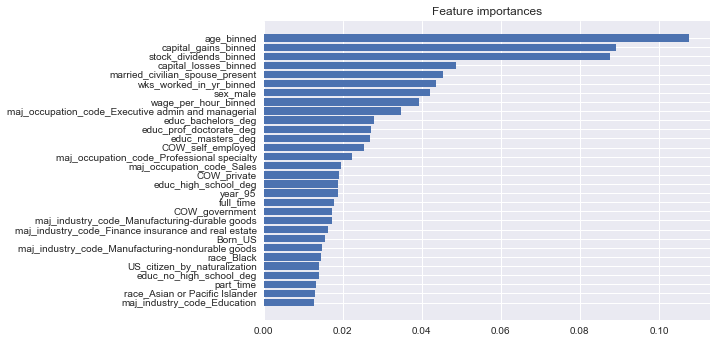

In [285]:
plot_feature_importances(gbc_grid2, x, num_feats=30)

Partial dependence plots for additional color...

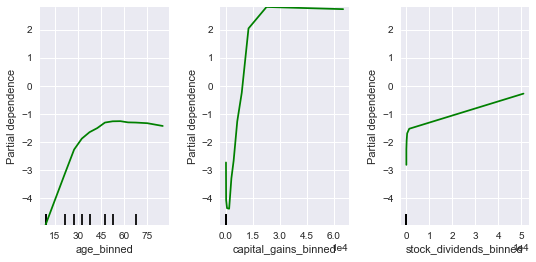

In [269]:
fig, axes = plot_partial_dependence(gbc_grid2, x, 
                                    features=[2,17,19], 
                                    feature_names=x.columns)
plt.show()

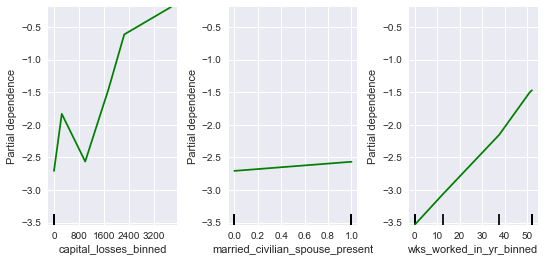

In [257]:
fig, axes = plot_partial_dependence(gbc_grid2, x, 
                                    features=[18,16,27], 
                                    feature_names=x.columns)
plt.show()

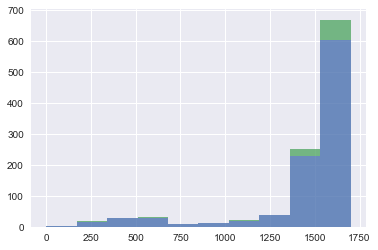

In [275]:
plot_stacked_hist(df, 'capital_losses',range=(1,1700))

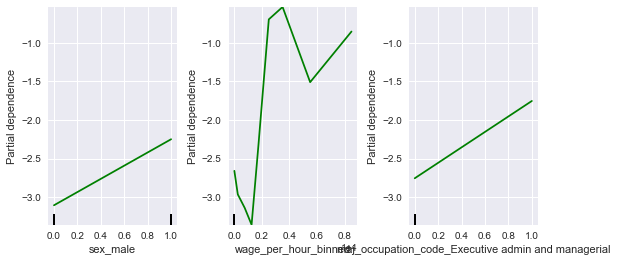

In [259]:
fig, axes = plot_partial_dependence(gbc_grid2, x, 
                                    features=[12,21,29], 
                                    feature_names=x.columns)
plt.show()

Zoom in to wage/hr

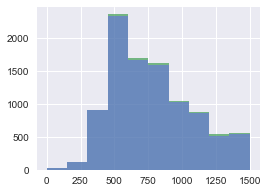

In [282]:
plot_stacked_hist(df,'wage_per_hour',range=(1,1500), figsize=(4,3))

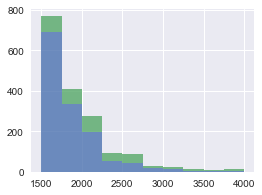

In [280]:
plot_stacked_hist(df,'wage_per_hour',range=(1500,4000), figsize=(4,3))

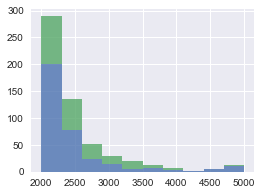

In [283]:
plot_stacked_hist(df,'wage_per_hour',range=(2000,5000), figsize=(4,3))

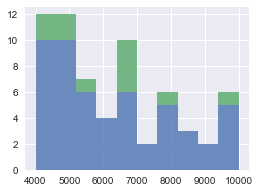

In [284]:
plot_stacked_hist(df,'wage_per_hour',range=(4000,10000), figsize=(4,3))

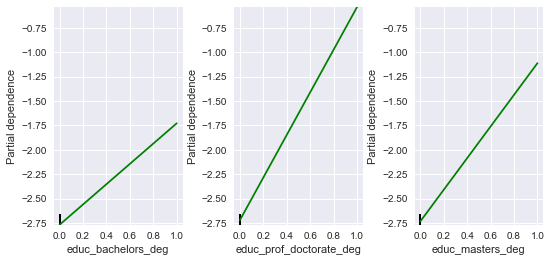

In [261]:
fig, axes = plot_partial_dependence(gbc_grid2, x, 
                                    features=[6,8,7], 
                                    feature_names=x.columns)
plt.show()

# Final Model Scored Against Unseen Data

In [262]:
test_df = initial_data_processing('data/census_income_test.csv', col_dict)
test_df = preprocess_data(test_df)

In [266]:
x_test_final = df_processed.drop(['income_binary'], axis=1)
y_test_final = df['income_binary']

In [267]:
score_model(gbc_grid2, x_test_final, y_test_final)

Accuracy: 0.957
AUC: 0.721


Model accuracy and AUC in test data are fairly close to training data, so we haven't overfit the model too much

# Final Overview & Insights

Biggest Challenge:

* The biggest challenege I faced was figuring out the best way to create visualizations for categorical features with a binary outcome. In the past I've used mosaic plots to do this, but this was far too messy given the number of categories within certain features, such as country of birth. 
* After a bit of research, I decdided that a combination of a barplot of value counts along with a barplot of mean binary income values (from 0 to 1) would provide sufficient insight

Analysis:
* To analyze the data, I've looked at feature importances as well as partial dependency plots
* I should caveat that we shouldn't assign TOO much significance to the individual feature importances in our tree-based model. Rather we look at the top few features and recognize that these are some of the most important features, but we acknowledge that the feature importances can shift around a bit with slight adjustments to the model, and therefore new tree splits
* We pair the feature importances with partial dependency plots to see HOW each feature is associated with income

Key features correlated with income above/below $50k/year:

* Age: ~30-60 associated w/ higher income, much lower for younger group and slightly lower for older
* Capital Gains: low capital gains mean lower income (income is lower for this group than for the 0 capital gains group), while high capital gains mean higher income
* Stock Dividends: higher value assoc w/ higher income
* Capital Losses: low capital losses mean lower income (income is lower for this group than for the 0 capital losses group), while high capital losses mean higher income
* Married: being married assoc w/ higher income
* Weeks worked in year: higher value assoc w/ higher income
* Sex: being male assoc w/ higher income
* Wage per hour: up to ~1.5k assoc w/ lower income; 1.5k-$3.8k strongly assoc w/ higher income, weaker btw ~3.8k-5k, and after ~5k, it is strong again
* Exec Admin: assoc w/ higher income
* Bachelors degree: assoc w/ higher income
* Prof school degree: assoc w/ higher income
* Masters degree: assoc w/ higher income